In [1]:
import pandas as pd
import numpy as np
import json
import re
from plotnine import *
import plotnine


%matplotlib inline
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumBarunGothic'
plt.rcParams["font.size"] = 20
plt.rcParams["figure.figsize"] = (15,8)


# pandas max row 
pd.options.display.max_rows = 3000

In [2]:
trd = pd.read_csv('data\매매값_아파트정보.csv')
trd.head()

,Unnamed: 0,층,전용면적,계약일자,거래금액,아파트,지,PNU,번,층구분,세대수,층수
0,0,5,84.0,2017-01-10,36400.0,새샘마을9단지(중흥S클래스리버뷰),0,소담동05210000,0521,4.0,454.0,29.0
1,1,24,84.0,2017-01-20,39282.0,새샘마을9단지(중흥S클래스리버뷰),0,소담동05210000,0521,4.0,454.0,29.0
2,2,13,97.0,2017-01-21,49000.0,새샘마을3단지(모아미래도리버시티),0,소담동05500000,0550,4.0,4.0,29.0
3,3,7,97.0,2017-01-25,40800.0,새샘마을3단지(모아미래도리버시티),0,소담동05500000,0550,4.0,4.0,29.0
4,4,7,16.0,2017-01-01,8600.0,스타힐타워Ⅰ,0,보람동07430000,0743,1.0,4.0,8.0


## 1. 아파트별 가격과의 관계 분석

### 1.1 데이터

In [3]:
trd['동'] = trd['PNU'].str[:-8]
trd_re = trd.drop({'Unnamed: 0','PNU','지','번'},axis = 1)
trd_re['면적당가격'] = trd_re['거래금액'] / trd_re['전용면적']
trd_re

,층,전용면적,계약일자,거래금액,아파트,층구분,세대수,층수,동,면적당가격
0,5,84.0,2017-01-10,36400.0,새샘마을9단지(중흥S클래스리버뷰),4.0,454.0,29.0,소담동,433.333333
1,24,84.0,2017-01-20,39282.0,새샘마을9단지(중흥S클래스리버뷰),4.0,454.0,29.0,소담동,467.642857
2,13,97.0,2017-01-21,49000.0,새샘마을3단지(모아미래도리버시티),4.0,4.0,29.0,소담동,505.154639
3,7,97.0,2017-01-25,40800.0,새샘마을3단지(모아미래도리버시티),4.0,4.0,29.0,소담동,420.618557
4,7,16.0,2017-01-01,8600.0,스타힐타워Ⅰ,1.0,4.0,8.0,보람동,537.500000
...,...,...,...,...,...,...,...,...,...,...
24412,5,59.0,2021-02-18,7000.0,민석그린,1.0,0.0,5.0,전의면,118.644068
24413,5,49.0,2021-02-03,5200.0,도원,1.0,100.0,5.0,전동면,106.122449
24414,5,49.0,2021-02-23,5200.0,도원,1.0,100.0,5.0,전동면,106.122449
24415,7,59.0,2021-02-01,5000.0,무궁화,2.0,0.0,12.0,소정면,84.745763


In [4]:
# 아파트 기준 정렬
apt_recent = trd_re.groupby(['아파트','전용면적']).agg('first')
apt_recent = apt_recent[{'층구분','세대수','동','층수'}]
apt_recent = apt_recent.reset_index(level=[0,1])
apt_recent = apt_recent.loc[~(apt_recent['세대수'] == 0)]

In [5]:
#최근 5건
price_5 = []
for i in apt_recent.index :
    a = apt_recent.loc[i,'아파트']
    b = apt_recent.loc[i,'전용면적']

    df = trd_re[(trd_re['아파트'] == a) & (trd_re['전용면적'] == b) ]
    recent = df[-5:]
    price = recent['면적당가격'].mean()
    price_5.append(price)

apt_recent['최근5건'] = price_5

In [6]:
apt_recent.head()

,아파트,전용면적,층구분,동,층수,세대수,최근5건
2,SR파크센텀,17.0,1.0,나성동,8.0,50.0,579.411765
3,SR파크센텀,19.0,1.0,나성동,8.0,50.0,488.157895
4,SR파크센텀,20.0,1.0,나성동,8.0,50.0,547.500000
5,SR파크센텀,21.0,1.0,나성동,8.0,50.0,535.714286
6,SR파크센텀,23.0,1.0,나성동,8.0,50.0,497.826087


### 1.2 상관분석

In [7]:
corr = apt_recent.corr(method = 'pearson')
corr

,전용면적,층구분,층수,세대수,최근5건
전용면적,1.000000,0.601982,0.608331,0.124942,0.309133
층구분,0.601982,1.000000,0.963399,0.400307,0.702075
층수,0.608331,0.963399,1.000000,0.383778,0.710313
세대수,0.124942,0.400307,0.383778,1.000000,0.349529
최근5건,0.309133,0.702075,0.710313,0.349529,1.000000


층구분 >> 양의 상관관계 : 아파트 정보 / 지역정보 추가

In [8]:
apt_info = apt_recent.groupby('아파트').agg({'최근5건' : 'mean','세대수' : 'sum'})
apt_info = apt_info.reset_index()
apt_info.columns = ['아파트','평균','총세대수']
data = apt_recent.merge(apt_info)
data['세대비율'] = data['세대수'] / data['총세대수']
data.head()

,아파트,전용면적,층구분,동,층수,세대수,최근5건,평균,총세대수,세대비율
0,SR파크센텀,17.0,1.0,나성동,8.0,50.0,579.411765,529.722006,250.0,0.2
1,SR파크센텀,19.0,1.0,나성동,8.0,50.0,488.157895,529.722006,250.0,0.2
2,SR파크센텀,20.0,1.0,나성동,8.0,50.0,547.500000,529.722006,250.0,0.2
3,SR파크센텀,21.0,1.0,나성동,8.0,50.0,535.714286,529.722006,250.0,0.2
4,SR파크센텀,23.0,1.0,나성동,8.0,50.0,497.826087,529.722006,250.0,0.2


In [9]:
dong_info = apt_recent.groupby('동').agg({'최근5건' : 'mean','세대수' : 'sum'})
dong_info = dong_info.reset_index()
dong_info.columns = ['동','지역평균','공급수']
data = data.merge(dong_info)
data.tail()

,아파트,전용면적,층구분,동,층수,세대수,최근5건,평균,총세대수,세대비율,지역평균,공급수
514,해밀마을1단지,59.0,3.0,해밀동,25.0,930.0,706.271186,792.328491,1810.0,0.513812,860.196347,2605.0
515,해밀마을1단지,84.0,3.0,해밀동,25.0,780.0,1004.047619,792.328491,1810.0,0.430939,860.196347,2605.0
516,해밀마을1단지,120.0,3.0,해밀동,25.0,100.0,666.666667,792.328491,1810.0,0.055249,860.196347,2605.0
517,해밀마을2단지,84.0,3.0,해밀동,25.0,561.0,861.904762,961.998133,795.0,0.705660,860.196347,2605.0
518,해밀마을2단지,102.0,3.0,해밀동,25.0,234.0,1062.091503,961.998133,795.0,0.294340,860.196347,2605.0


In [10]:
corr = data.corr(method = 'pearson')
corr

,전용면적,층구분,층수,세대수,최근5건,평균,총세대수,세대비율,지역평균,공급수
전용면적,1.000000,0.601982,0.608331,0.124942,0.309133,0.389075,0.223095,0.023381,0.306982,0.273582
층구분,0.601982,1.000000,0.963399,0.400307,0.702075,0.744219,0.447268,0.127539,0.628626,0.234252
층수,0.608331,0.963399,1.000000,0.383778,0.710313,0.752429,0.422597,0.145492,0.661482,0.299695
세대수,0.124942,0.400307,0.383778,1.000000,0.349529,0.346238,0.762111,0.528330,0.253818,0.279463
최근5건,0.309133,0.702075,0.710313,0.349529,1.000000,0.944027,0.304821,0.105395,0.836204,0.215937
평균,0.389075,0.744219,0.752429,0.346238,0.944027,1.000000,0.322894,0.091634,0.885784,0.228740
총세대수,0.223095,0.447268,0.422597,0.762111,0.304821,0.322894,1.000000,0.093332,0.283543,0.220136
세대비율,0.023381,0.127539,0.145492,0.528330,0.105395,0.091634,0.093332,1.000000,-0.025628,0.171357
지역평균,0.306982,0.628626,0.661482,0.253818,0.836204,0.885784,0.283543,-0.025628,1.000000,0.258235
공급수,0.273582,0.234252,0.299695,0.279463,0.215937,0.228740,0.220136,0.171357,0.258235,1.000000


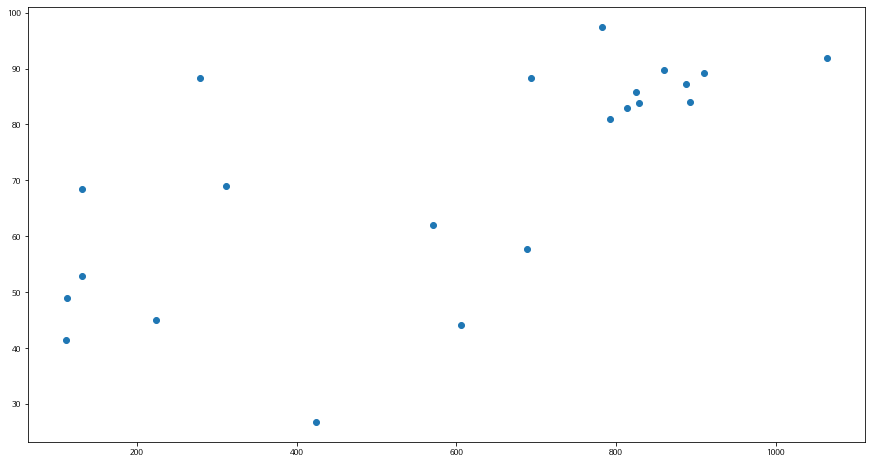

In [11]:
df01 = data.groupby('동').agg({'최근5건' : 'mean','층수' : 'first', '총세대수': 'first','전용면적' : 'mean'})
plt.scatter(df01['최근5건'],df01['전용면적'])
plt.show()

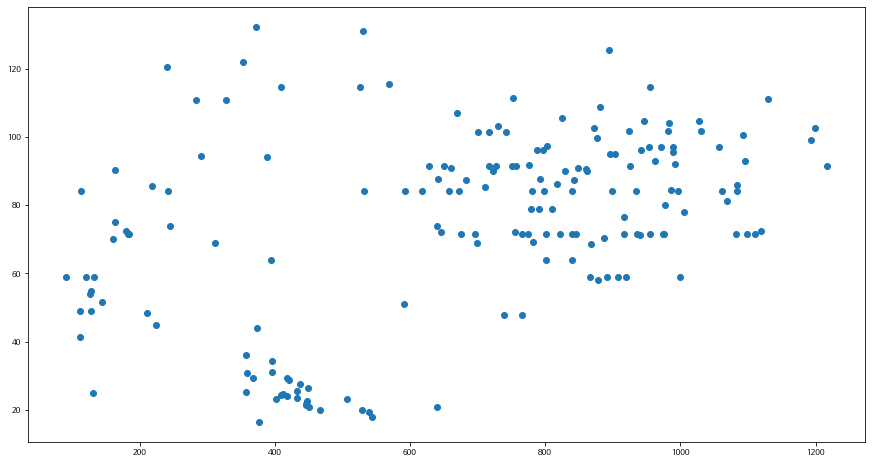

In [12]:
df01 = data.groupby('아파트').agg({'최근5건' : 'mean','층수' : 'first', '총세대수': 'first','전용면적' : 'mean'})
plt.scatter(df01['최근5건'],df01['전용면적'])
plt.show()

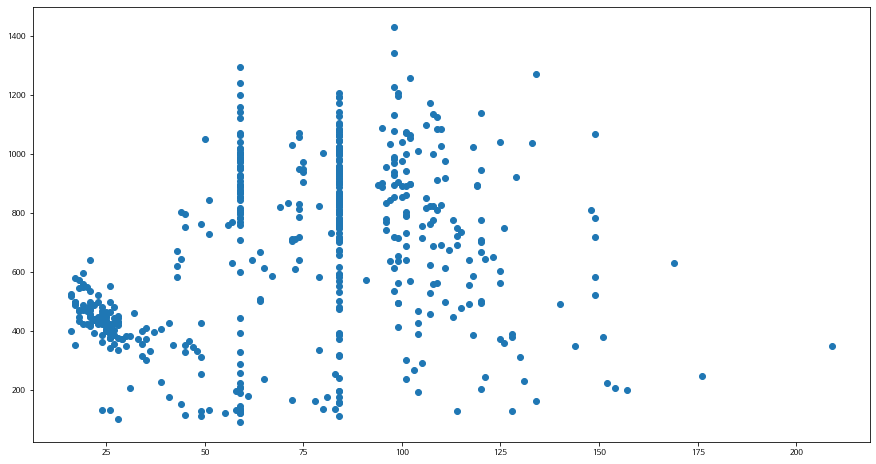

In [14]:
plt.scatter(data['전용면적'],data['최근5건'])
plt.show()